In [1]:
import math
import utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from scipy.ndimage import map_coordinates
from scipy.ndimage import zoom
#from cotracker.utils.visualizer import Visualizer, read_video_from_path
#from cotracker.models.core.model_utils import get_points_on_a_grid

#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

device = "cuda"


KeyboardInterrupt



In [2]:
frames = utils.load_example_experiment()
#frames = corr.denoise_stack(frames)
#frames = np.array([corr.uint8_to_float32(frame) for frame in frames])
video = (torch.tensor(np.array(frames)).to(device)
         .unsqueeze(0).unsqueeze(2).repeat(1,1,3,1,1).float() * 255.0)
#convert to  # B T C H W format with "fake" rgb

In [15]:
video.shape

torch.Size([1, 764, 3, 258, 512])

In [3]:
cotracker = (torch.hub.load("facebookresearch/co-tracker", "cotracker3_online").to
             (device))
cotracker(video_chunk=video, is_first_step=True, grid_size=15)

for idx in range(0, video.shape[1] - cotracker.step, cotracker.step):
    pred_tracks, pred_visibility = cotracker(video_chunk=video[:,
                                                         idx:idx + cotracker.step*2])

Using cache found in C:\Users\morit/.cache\torch\hub\facebookresearch_co-tracker_main


In [4]:
video[0,0]

tensor([[[ 0.2529,  0.1829,  1.7432,  ...,  0.2179,  0.2374,  0.8794],
         [ 0.2101,  0.2335,  0.4047,  ...,  0.1790,  0.2101,  0.1673],
         [ 3.0778,  0.2023,  0.2529,  ...,  0.1595,  0.2296,  0.2062],
         ...,
         [ 4.2101,  0.2296,  2.8405,  ...,  0.1984,  0.2023,  0.7160],
         [ 7.1751,  3.1829,  3.7860,  ...,  0.1984,  4.7821, 13.0545],
         [ 0.2335,  0.1673,  2.1128,  ...,  5.5564, 10.6226,  9.8249]],

        [[ 0.2529,  0.1829,  1.7432,  ...,  0.2179,  0.2374,  0.8794],
         [ 0.2101,  0.2335,  0.4047,  ...,  0.1790,  0.2101,  0.1673],
         [ 3.0778,  0.2023,  0.2529,  ...,  0.1595,  0.2296,  0.2062],
         ...,
         [ 4.2101,  0.2296,  2.8405,  ...,  0.1984,  0.2023,  0.7160],
         [ 7.1751,  3.1829,  3.7860,  ...,  0.1984,  4.7821, 13.0545],
         [ 0.2335,  0.1673,  2.1128,  ...,  5.5564, 10.6226,  9.8249]],

        [[ 0.2529,  0.1829,  1.7432,  ...,  0.2179,  0.2374,  0.8794],
         [ 0.2101,  0.2335,  0.4047,  ...,  0

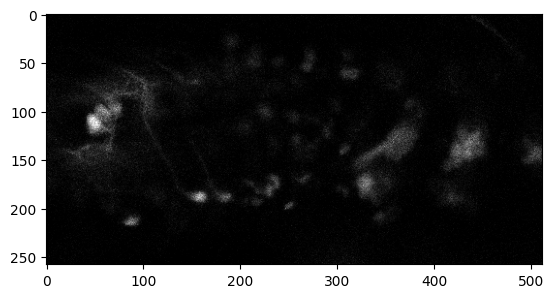

In [5]:
plt.imshow(video[0,0].permute(1,2,0).cpu() / 255.0)
plt.show()

In [6]:
test_frame = frames[0]
print(test_frame.dtype)
test_frame = utils.float32_to_uint8(test_frame)
print(test_frame.dtype)

float32
uint8


In [7]:
#img = Image.fromarray(test_frame)
#print(img.format)
#img.show()

In [8]:
from cotracker.utils.visualizer import Visualizer

vis = Visualizer(save_dir="./saved_videos")

In [9]:
result = vis.visualize(video, pred_tracks, pred_visibility)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (512, 258) to (512, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ./saved_videos\video.mp4


In [10]:
pred_tracks.cpu().shape

torch.Size([1, 764, 225, 2])

In [11]:
#luisas code
def warping(predicted_tracks, frames):
    """
    Warps the frames of a video based on predicted tracks.
    args:
        predicted_tracks (torch.Tensor): Predicted tracks of shape (B, T, G, D).
        frames (torch.Tensor): Video frames of shape (T_orig, H, W, C).
    returns:
        warpeds (list): List of warped frames.
    """
    T_orig, H, W, C = frames.shape
    B, T, G, D = predicted_tracks.shape
    grid_size = int(math.sqrt(G))

    velocity = predicted_tracks[0].reshape(T, grid_size, grid_size, 2) #(764, 32, 32, 2)
    print(velocity.shape)
    real_velocity = velocity-velocity[0] # (764, 32, 32, 2)
    v = real_velocity.transpose(0, 3, 1, 2) # (764, 2, 32, 32)
    print(v.shape)
    print(f"{W/grid_size=}")
    vp = zoom(v, (1, 1, W/grid_size, H/grid_size))  #(764, 2, 34, 17)
    print(vp.shape)
    #warpeds = [frames[0][...,0]]
    warpeds = []
    for i in range(1,T_orig):
        grid_x, grid_y = np.meshgrid(np.arange(H), np.arange(W))
        print(grid_x.shape)
        print(grid_y.shape)
        grid_x = grid_x.astype(np.float32)
        grid_y = grid_y.astype(np.float32)

        phi = np.diff(vp,axis=0)[0:i].sum(0)
        print(phi.shape)
        grid_x += phi[0]
        grid_y += phi[1]

        warped = map_coordinates(frames[i][...,0].astype(np.float32), [grid_x, grid_y],
                                 order=3, mode='nearest')
        print(warped.shape)
        warpeds.append(warped)
    return np.array(warpeds)

In [12]:
frames = np.array(frames)
frames = np.expand_dims(frames, axis=3)
frames.shape

(764, 258, 512, 1)

In [13]:
pred_tracks[0].shape

torch.Size([764, 225, 2])

In [14]:
frames.shape

(764, 258, 512, 1)

In [15]:
warped_frames = warping(pred_tracks.cpu().numpy(), np.moveaxis(video.cpu().numpy().squeeze(), 1, -1))

(764, 15, 15, 2)
(764, 2, 15, 15)
W/grid_size=34.13333333333333
(764, 2, 512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2, 512, 258)
(512, 258)
(512, 258)
(512, 258)
(2

In [16]:
np.moveaxis(video.cpu().numpy().squeeze(), 1, -1).shape

(764, 258, 512, 3)

In [17]:
warped_frames[0].shape

(512, 258)

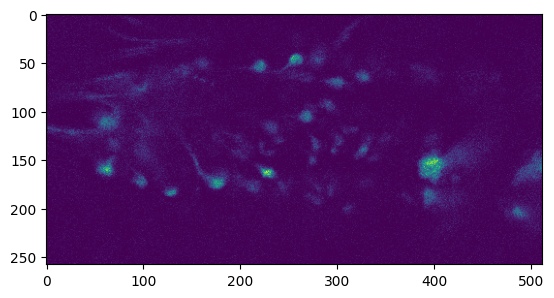

In [18]:
plt.imshow(frames[500])
plt.show()

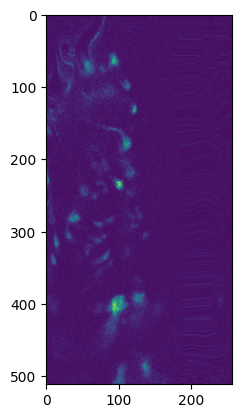

In [19]:
plt.imshow(warped_frames[500])# this transpose is most likely a symptom
# of a huge problem
plt.show()

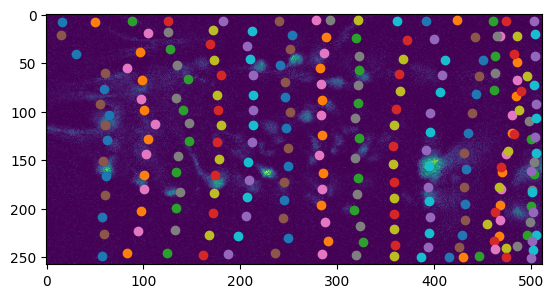

In [20]:
plt.imshow(frames[500])
for x, y in pred_tracks.cpu().numpy()[0][500]:
    plt.scatter(x, y)

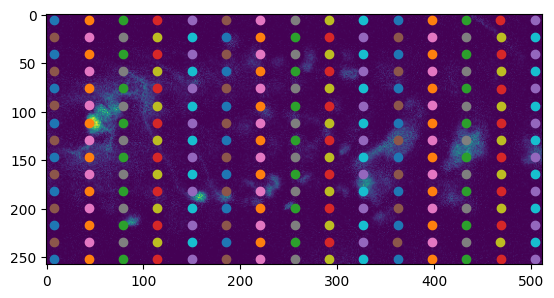

In [21]:
plt.imshow(frames[0])
for x, y in pred_tracks.cpu().numpy()[0][0]:
    plt.scatter(x, y)

In [22]:
import gc

torch.cuda.empty_cache()
#del frames
#del video

#del cotracker
#del vis
#del pred_tracks, pred_visibility
gc.collect()


55134

In [ ]:
from matplotlib import animation

fig, ax = plt.subplots()
writer = animation.FFMpegWriter(fps=10)

with writer.saving(fig, "cotracker_warped.mp4", dpi=100):
    for frame in warped_frames:
        ax.clear()
        ax.imshow(frame.transpose(), cmap="gray")
        #for y, x, sigma in blobs:
            #circle = plt.Circle((x, y), sigma*np.sqrt(2), edgecolor="r", fill=False,
            # lw=1)
            #ax.add_patch(circle)
        ax.axis("off")
        writer.grab_frame()